# Simple forecasting techniques

## The importance of a baseline model

In this notebook we will explore some simple forecasting techniques.  Selecting on of these simple techniques should on of your early decisions in a time series forecasting project. Although each represents simple approach to forecasting they are from a family of techniques used for setting a statistical baseline. Before you move onto complex methods make sure you use a baseline.  Any complex model must be better than the baseline to be considered for forecasting.  This is a often a missed step in forecasting where there is a temptation to use complex methods.

The methods we will explore are:

* Average Forecast
* Naive Forecast 1
* Seasonal Naive
* Naive with Drift

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.style as style
from statsmodels.tsa.seasonal import seasonal_decompose

style.use('ggplot')

In [2]:
def preds_as_series(data, preds):
    '''
    Helper function for plotting predictions.
    Converts a numpy array of predictions to a 
    pandas.DataFrame with datetimeindex
    
    Parameters
    -----
    preds - numpy.array, vector of predictions
    start - start date of the time series
    freq - the frequency of the time series e.g 'MS' or 'D'
    '''
    start = pd.date_range(start=data.index.max(), periods=2, freq=data.index.freq).max()
    idx = pd.date_range(start=start, periods=len(preds), freq=data.index.freq)
    return pd.DataFrame(preds, index=idx)

## The ED arrivals dataset.

The dataset we will use represent monthly adult (age > 18) arrivals to an Emergency Department.  The observations are between April 2009 and May 2017. Our forecasting task is to predict the next four months.

In [3]:
ed_month = pd.read_csv('data/ed_mth_ts.csv', index_col='date', parse_dates=True)
ed_month.index.freq = 'MS'

In [4]:
ed_month.index.min()

Timestamp('2009-04-01 00:00:00', freq='MS')

In [5]:
ed_month.index.max()

Timestamp('2017-05-01 00:00:00', freq='MS')

### Visualise the time series

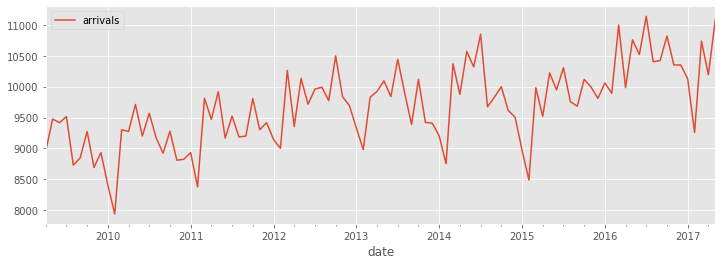

In [6]:
ed_month.plot(figsize=(12,4))

### Adjust the monthly data

Remember that some of the noise you are seeing the time series is due to months having a different number of days.  This makes forecasting harder than it needs to be.  Adjusting the time series by dividing by the number of days per month removes that noise.  Note that units are now people per day.

In [7]:
arrival_rate = ed_month['arrivals'] / ed_month.index.days_in_month

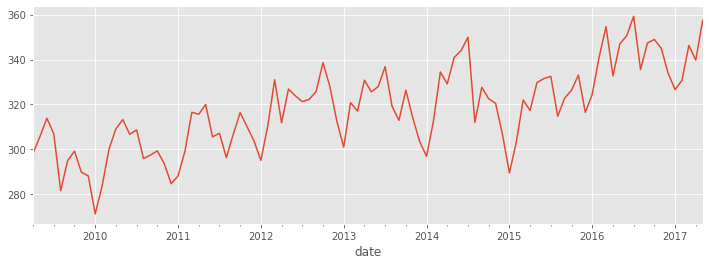

In [8]:
arrival_rate.plot(figsize=(12,4))

## Mean Forecast

One of the simpliest baseline's is to take the average of the historical observations and project that forward. i.e. 

**The *mean forecast = sum of historical observations / number of historical values*.**

It is useful to write this in a slighly more compact mathematical form.

If the historical observation at time 1 = $y_1$ and at time 2 = $y_2$ the the times series can be represented as a series of observations between 1 and T (the final observation) $y_1, y_2 ... y_T$

The mean forecast given the historical observations $\hat{y}_{T+h|y_1, y_2 ... y_T}$ is therefore

$\hat{y}_{T+h|T} = \frac{\sum_{t=1}^{T}y_t}{T}$

PenCHORD has implemented some simple classes for baseline forecasts in a package called `forecast`.  

For a mean forecast the class to use is

```python
forecast.baseline.Average
```

There are three steps to use it

* Create an instance of the class
* Call the `fit` method and pass in the historical data
* Call the `predict` method and pass in a chosen forecast horizon e.g. 12 months. 

In [9]:
#import the mean forecast class
from forecast.baseline import Average

In [10]:
#create an instance of the average class
avg = Average()

In [11]:
#fit the historical data
avg.fit(arrival_rate)

In [12]:
#call the predict method, choosing a prediction horizon
avg_preds = avg.predict(horizon=12)

In [13]:
#the method returns predictions as a numpy vector of length horizon.
avg_preds

array([318.06265589, 318.06265589, 318.06265589, 318.06265589,
       318.06265589, 318.06265589, 318.06265589, 318.06265589,
       318.06265589, 318.06265589, 318.06265589, 318.06265589])

Let's visualise the forecast relative to the training data.

* Do you think this is a good baseline?

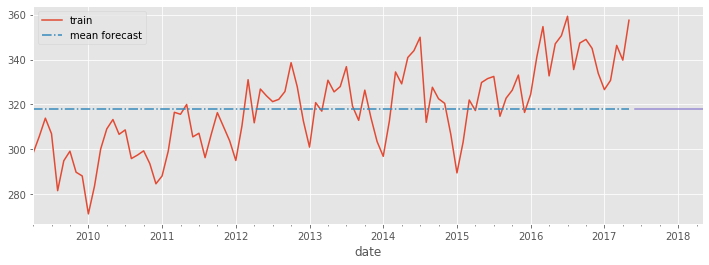

In [14]:
ax = arrival_rate.plot(figsize=(12,4))
avg.fittedvalues.plot(ax=ax, linestyle='-.')
preds_as_series(arrival_rate, avg_preds).plot(ax=ax)
ax.legend(['train', 'mean forecast'])

## Naive Forecast 1

An alternative and popular baseline forecast is Naive Forecast 1.  This simply takes the last value in the time series and extrapolates it forward over the forecast horizon.  I.e.

**Naive Forecast = Last value in the time series**

In mathematical notation:

$\hat{y}_{T+h|T} =y_t$

You can create a Naive1 forecast following the same steps as for the average forecast and using an object of type:
```python
forecast.baseline.Naive1
```

In [15]:
from forecast.baseline import Naive1

In [16]:
nf1 = Naive1()
nf1.fit(arrival_rate)
nf1_preds = nf1.predict(horizon=12)

In [17]:
nf1_preds

array([357.51612903, 357.51612903, 357.51612903, 357.51612903,
       357.51612903, 357.51612903, 357.51612903, 357.51612903,
       357.51612903, 357.51612903, 357.51612903, 357.51612903])

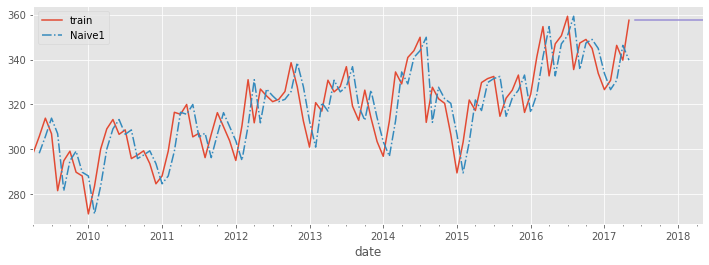

In [18]:
ax = arrival_rate.plot(figsize=(12,4))
nf1.fittedvalues.plot(ax=ax, linestyle='-.')
preds_as_series(arrival_rate, nf1_preds).plot(ax=ax).plot(ax=ax)
ax.legend(['train', 'Naive1'])

## Seasonal Naive

Seasonal Naive extends Naive1 in an attempt to incorporate the seasonality in the data.  Instead of carrying the final value in the time series forward it carries forward the value from the previous time period.  As we are working with monthly data this means that a forecast for Janurary will use the previous Janurary's observation. A forecast for February will use the previous February's observation and so on.

In [19]:
from forecast.baseline import SNaive

In [20]:
snf = SNaive(period=12)
snf.fit(arrival_rate)
snf_preds = snf.predict(horizon=12)

In [21]:
snf_preds

array([350.63333333, 359.29032258, 335.5483871 , 347.36666667,
       348.96774194, 344.96666667, 333.87096774, 326.61290323,
       330.71428571, 346.32258065, 339.73333333, 357.51612903])

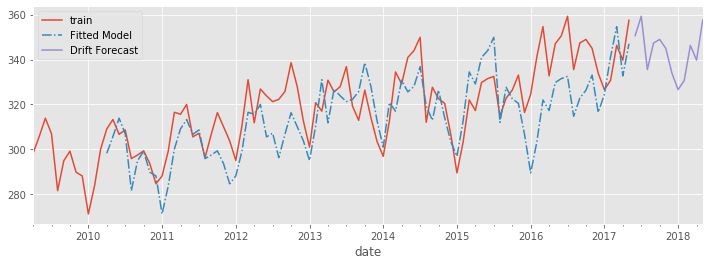

In [27]:
ax = arrival_rate.plot(figsize=(12,4))
snf.fittedvalues.plot(ax=ax, linestyle='-.')
preds_as_series(arrival_rate, snf_preds).plot(ax=ax).plot(ax=ax)
ax.legend(['train','Fitted Model', 'Drift Forecast'])

## Drift Method

So far the baseline methods have not considered an increasing or decreasing trend within the forecast.  A simple method to do this adjusting Naive1 to account for the average change in historical observations between the first period and the last.  This average change is called the **drift**.

In words the method is equivalent to taking a ruler and drawing a line between the first and last value in the series.  To forecast you then extend that line into the future for $h$ periods.

Mathematically a drift forecast is defined as:

$\hat{y}_{T+h|T} =y_t + h \left(\frac{y_T - y_1}{T - 1} \right)$


In [23]:
from forecast.baseline import Drift

In [24]:
drf = Drift()
drf.fit(arrival_rate)
drf_preds = drf.predict(horizon=12)

In [25]:
drf_preds

array([358.12694823, 358.73776743, 359.34858663, 359.95940583,
       360.57022503, 361.18104423, 361.79186343, 362.40268263,
       363.01350183, 363.62432103, 364.23514023, 364.84595943])

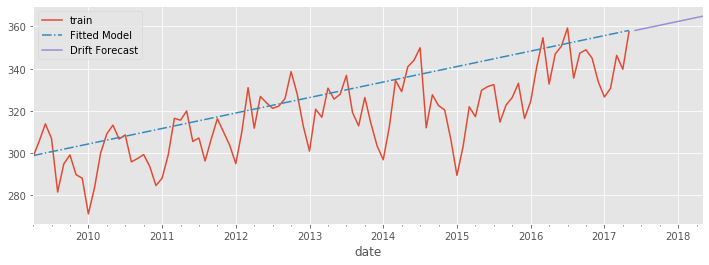

In [26]:
ax = arrival_rate.plot(figsize=(12,4))
drf.fittedvalues.plot(ax=ax, linestyle='-.')
preds_as_series(arrival_rate, drf_preds).plot(ax=ax).plot(ax=ax)
ax.legend(['train','Fitted Model', 'Drift Forecast'])